# 04 - Unconstrained Matrix Factorization
This notebook develops our first model-based algorithm - unconstrained matrix factorization, using the Surprise library's SVD algorithm. Similarly to how we implemented our learned baseline model, we use Hyperopt's tree parzen estimator to search for a set of hyperparameters that minimizes the 3-fold cross-validated MAE of the SVD model, visualize the effect of each hyperparameter setting on MAE, and perform a runtime analysis for different sample sizes.

In [2]:
from surprise import Dataset, evaluate, SVD, Reader

from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

sns.set(style='whitegrid')
% matplotlib inline

In [3]:
# set file paths and read in samples
data_path = os.path.join('..','..','data')
data_file_100 = os.path.join(data_path, 'reviews_sample_100.csv')
data_file_50 = os.path.join(data_path, 'reviews_sample_50.csv')
data_file_25 = os.path.join(data_path, 'reviews_sample_25.csv')
data_file_10 = os.path.join(data_path, 'reviews_sample_10.csv')

df_100 = pd.read_csv(data_file_100).drop('Unnamed: 0', axis = 1)
df_50 = pd.read_csv(data_file_50).drop('Unnamed: 0', axis = 1)
df_25 = pd.read_csv(data_file_25).drop('Unnamed: 0', axis = 1)
df_10 = pd.read_csv(data_file_10).drop('Unnamed: 0', axis = 1)

In [30]:
reader = Reader(rating_scale=(1,5))
sdf_100 = Dataset.load_from_df(df_100[['reviewerID', 'asin', 'overall']], reader=reader)

Surprise's SVD model can be tuned with three hyperparameters:
1. n_epochs: the number of epochs a model trains for prior to termination
2. n_factors: number of latent factors
3. reg_all: regularization for all parameters

To search for optimal hyperparameter values, we eschew grid search for a more efficient and effective Bayesian optimization method using **tree parzen estimators** provided by the Hyperopt library.

In [31]:
def test_svd(params): 
    '''Test SVD with specified hyperparameter settings and define cross-validated MAE as loss.
       This function will later be fed into fmin to find optimized hyperparameters.
    '''
    model = SVD(**params)
    
    # split the dataset into three folds for cross-validation
    sdf_100.split(3, shuffle=True)
    results = evaluate(model, sdf_100, measures = ['mae'], verbose=True)
    mae = np.array(results['mae']).mean()
    return mae

In [34]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'trials_svd'), 'rb') as file_in:
        trials = pkl.load(file_in)
    with open(os.path.join(data_path, 'best_svd.dict'), 'rb') as file_in:
        best = pkl.load(file_in)
else:
    '''set the range of hyperpatameters for the SVD model
       n_factors: The number of factors
       n_epochs: number of iterations the SGD procedure will be performed
       reg_all: The regularization term for all parameters in SVD
    '''
    trials = Trials()
    space = {
        'n_factors': hp.choice('n_factors', list(range(10, 61))),
        'n_epochs': hp.choice('n_epochs', list(range(10,31))),
        'reg_all': hp.uniform('reg_all', 0, 0.1)
    }
    
    '''Use Tree-structured Parzen Estimator (TPE) as the algorithm used
       to optimize the objective function'''
    best = fmin(algo = tpe.suggest,
               fn = test_svd,
               trials = trials,
               max_evals = 100,
               space = space)
    with open(os.path.join(data_path, 'trials_svd'), 'wb') as file_out:
        pkl.dump(trials, file_out)
    with open(os.path.join(data_path, 'best_svd.dict'), 'wb') as file_in:
        pkl.dump(best, file_in)

This section below, accompanied by various graphs, visulizes the distribution of the different values each hyperparameter can take and the corresponding loss values.

In [143]:
def val_diagnostic(val_name, trials):
    '''generates scatter plot and histogram of each parameter, as well as a plot on loss values (MAE)'''
    vals = np.array([trial['misc']['vals'][val_name] for trial in trials.trials])
    
    '''For hyperparameters that are specified with hp.choice, such as a range of integers,
       Hyperopt returns the index of the tested hyperparameter value rather than the value itself.
       Thus, for hyperparameter ranges that begin at a non-zero point,
       it is necessary to shift the indices to the corresponding values they represent.
    '''
    if val_name == 'n_epochs':
        vals += 10
    elif val_name == 'n_factors':
        vals += 10
        
    ts = [trial['tid'] for trial in trials.trials]
    results = [trial['result']['loss'] for trial in trials.trials]
    
    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    axes[0].scatter(ts, vals)
    axes[0].set(xlabel='iteration', ylabel=val_name)
    axes[1].hist(np.array(vals).squeeze())
    axes[1].set(xlabel=val_name, ylabel='frequency')
    axes[2].scatter(vals, results)
    axes[2].set(xlabel=val_name, ylabel='loss')
    plt.tight_layout()

For each hyperparameter, namely the number of latent factors, number of epochs, and the regularization term, we make three plots to understand its distribution and performance. The first and second graphs are respectively a scatterplot and a histogram, in order to visualize where the values tend to cluster as the algorithm optimizes. The third graph is a loss vs. values plot that visualizes how MAE changes with hyperparameter different values. The algorithm picks the combination of hyperparameter values where loss is minimized.

As we can see from the graphs, the model tends to perform better when the number of epochs is around 28 and the number of latent factors is around 10. Values for the regularization term tend to be distributed more evenly and tend to produce slightly better results when between 0.02 and 0.04.

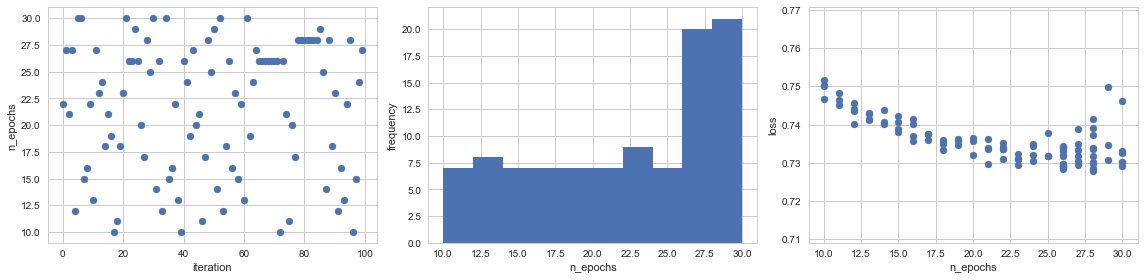

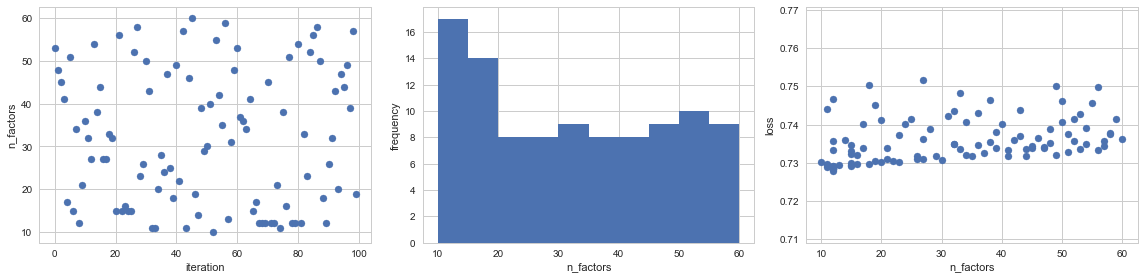

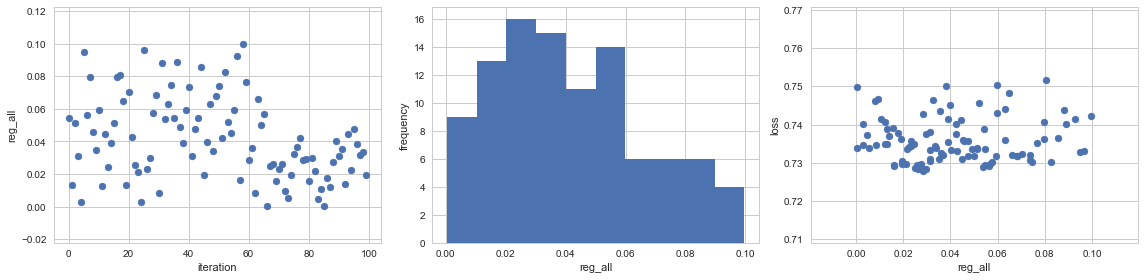

In [144]:
for val in trials.trials[0]['misc']['vals'].keys():
    val_diagnostic(val, trials)

In [35]:
# optimized hyperparameter values
best_adjusted = best.copy()
best_adjusted['n_epochs'] += 10
best_adjusted['n_factors'] += 10
best_adjusted

{'n_epochs': 28, 'n_factors': 12, 'reg_all': 0.02850989250919593}

In [37]:
# feed in the optimized hyperparameters to SVD and evaluate 5-fold cross-validated MAE
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'results_svd.array'), 'rb') as file_in:
        results = pkl.load(file_in)
else:
    model = SVD(**best_adjusted)
    sdf_100.split(5)
    results = evaluate(model, sdf_100, measures = ['mae'])
    with open(os.path.join(data_path, 'results_svd.array'), 'wb') as file_out:
        pkl.dump(results, file_out)

Using the optimized hyperparameters, we find the median MAE of the SVD model to be around 0.725.

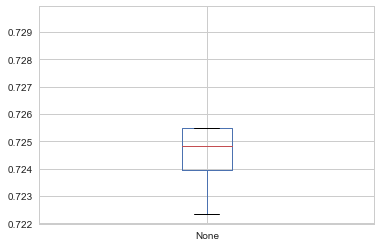

In [38]:
pd.Series(results['mae']).plot(kind = 'box')

# Runtime analysis
In this part of the notebook, we run the SVD model with different sample sizes in order to explore how runtime scales as sample size increases. For each sample size, we run the model for 1 iteration, and record the difference between start time and end time.

In [151]:
'''run the SVD model on different samplze sizes and calculate runtime.'''
df_list = [df_10, df_25, df_50, df_100]

use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'runtime_svd.list'), 'rb') as file_in:
        runtime_list = pkl.load(file_in)
else:
    runtime_list = list()
    for df in df_list:
        sdf = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader=reader)
        
        # use the entire dataset without splitting into folds
        train = sdf.build_full_trainset()

        start = time.time()
        model.train(train)
        end = time.time()

        runtime_list.append(end-start)

    with open(os.path.join(data_path, 'runtime_svd.list'), 'wb')as file_out:
        pkl.dump(runtime_list, file_out)

Here we observe that, for the SVD model with optimized parameters, runtime tends to scale linearly as sample size increases.

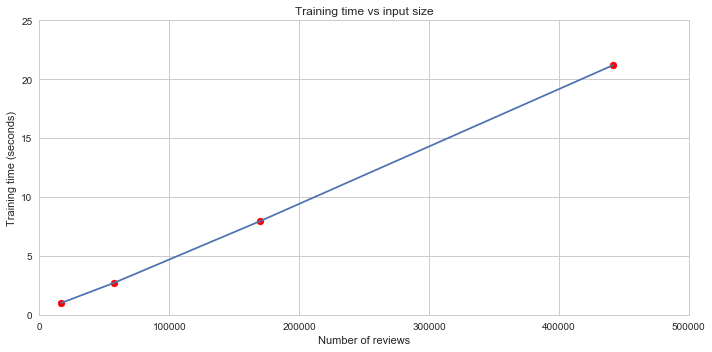

In [152]:
# plot runtime against sample sizes
n_reviews_list = [len(df) for df in df_list]
plt.figure(figsize = (10, 5))
plt.plot(n_reviews_list, runtime_list)
plt.scatter(n_reviews_list, runtime_list, color = 'red')
plt.ylim(0, 25)
plt.xlim(0, 500000)
plt.xlabel('Number of reviews')
plt.ylabel('Training time (seconds)')
plt.title('Training time vs input size')
plt.tight_layout()